In [1]:
import tensorflow as tf

In [2]:
input_shape=(224,224)
train_take=.8
test_take=.5

In [3]:
import math
train_ds = tf.keras.utils.image_dataset_from_directory(
  'data',
  validation_split=1-train_take,
  subset="training",
  seed=123,
  image_size=input_shape,
  batch_size=32).shuffle(1000)
non_train_ds = tf.keras.utils.image_dataset_from_directory(
  'data',
  validation_split=1-train_take,
  subset="validation",
  seed=123,
  image_size=input_shape,
  batch_size=32).shuffle(1000)
val_ds=non_train_ds.take(math.ceil(non_train_ds.cardinality().numpy()*(1-test_take)))
test_ds=non_train_ds.take(math.floor(non_train_ds.cardinality().numpy()*(test_take)))
print("train size: "+str(train_ds.cardinality()))
print("val size: "+str(val_ds.cardinality()))
print("test size: "+str(test_ds.cardinality()))

Found 4188 files belonging to 4 classes.
Using 3351 files for training.
Found 4188 files belonging to 4 classes.
Using 837 files for validation.
train size: tf.Tensor(105, shape=(), dtype=int64)
val size: tf.Tensor(14, shape=(), dtype=int64)
test size: tf.Tensor(13, shape=(), dtype=int64)


In [4]:
class_names=['Blight','Common Rust','Gray Leaf Spot','Healthy']

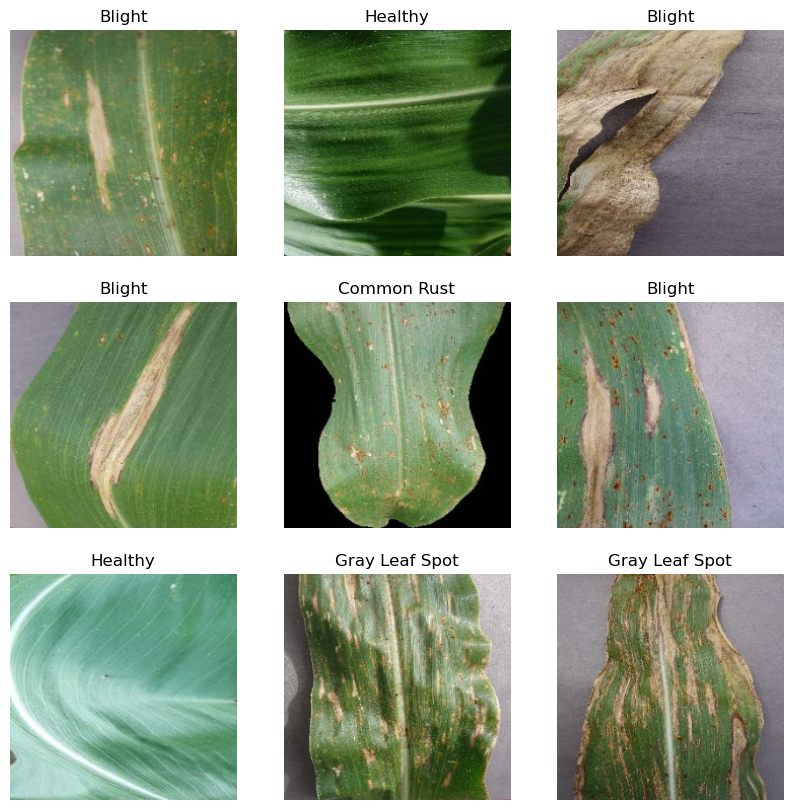

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [7]:
#Use MobileNet for trasnsfer learning
base_model=tf.keras.applications.mobilenet_v2.MobileNetV2(include_top=False)
for layer in base_model.layers:
    layer.trainable=False
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip("horizontal_and_vertical"),
  tf.keras.layers.RandomRotation(1),
])
_input=data_augmentation(base_model.input)
preprocessed=tf.keras.applications.mobilenet_v2.preprocess_input(_input)
base_model_output=base_model(preprocessed)
avg=tf.keras.layers.GlobalAveragePooling2D()(base_model_output)
hidden=tf.keras.layers.Dense(32,activation='relu')(avg)
output=tf.keras.layers.Dense(len(class_names),activation='softmax')(hidden)
model=tf.keras.Model(inputs=base_model.input,outputs=output)
model.summary()

C:\Users\tonyb\AppData\Local\Temp\ipykernel_30892\2589416557.py:2: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model=tf.keras.applications.mobilenet_v2.MobileNetV2(include_top=False)


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, None, None, 3)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential (Sequential)              │ (None, None, None, 3)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ true_divide (TrueDivide)             │ (None, None, None, 3)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ subtract (Subtract)                  │ (None, None, None, 3)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ mobilenetv2_1.00_224 (Functional)    │ (None, None, None, 1280)    │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 32)                  │          40,992 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │             132 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,299,108 (8.77 MB)

 Trainable params: 41,124 (160.64 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [9]:
model.compile('nadam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])
model.fit(train_ds,validation_data=val_ds,epochs=10,callbacks=[tf.keras.callbacks.EarlyStopping(min_delta=0,patience=3)])

Epoch 1/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 123s 1s/step - accuracy: 0.7468 - loss: 0.6254 - val_accuracy: 0.8929 - val_loss: 0.2656
Epoch 2/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 108s 1s/step - accuracy: 0.9123 - loss: 0.2272 - val_accuracy: 0.9241 - val_loss: 0.2089
Epoch 3/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 107s 1s/step - accuracy: 0.9362 - loss: 0.1638 - val_accuracy: 0.9121 - val_loss: 0.1973
Epoch 4/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 109s 1s/step - accuracy: 0.9390 - loss: 0.1598 - val_accuracy: 0.8741 - val_loss: 0.2785
Epoch 5/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 103s 959ms/step - accuracy: 0.9385 - loss: 0.1593 - val_accuracy: 0.8996 - val_loss: 0.2498
Epoch 6/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 101s 941ms/step - accuracy: 0.9448 - loss: 0.1450 - val_accuracy: 0.8931 - val_loss: 0.2163


In [10]:
import numpy as np
confusion_matrix=np.zeros([4,4])
true_labels=np.zeros([14*32])
predictions=np.zeros([14*32])
i=0
for item in val_ds:
    output=model.predict(item[0])
    output=np.argmax(output,axis=-1)
    for true,prediction in zip(item[1],output):
        true_labels[i]=true.numpy()
        predictions[i]=prediction
        i+=1
from sklearn.metrics import confusion_matrix
confusion_mat=np.float32(confusion_matrix(true_labels,predictions))
print(confusion_mat)

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 923ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 966ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 936ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 891ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 950ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 910ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 910ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 945ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 919ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 919ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 932ms/step
[[116.   4.  16.   0.]
 [  2. 119.   4.   0.]
 [  8.   1.  49.   0.]
 [  1.   0.   0. 128.]]


In [11]:
for i,row in enumerate(confusion_mat):
    confusion_mat[i]/=np.sum(row)
print(confusion_mat)

[[0.85294116 0.02941176 0.11764706 0.        ]
 [0.016      0.952      0.032      0.        ]
 [0.13793103 0.01724138 0.8448276  0.        ]
 [0.00775194 0.         0.         0.99224806]]


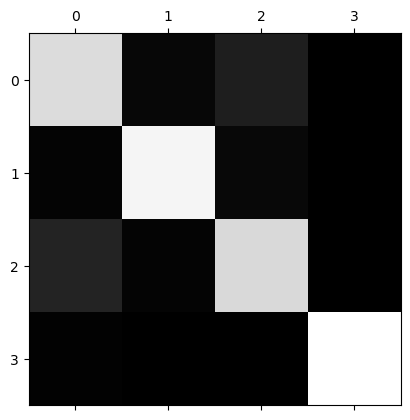

In [12]:
import matplotlib.pyplot as plt
plt.matshow(confusion_mat,cmap=plt.cm.gray)